In [1]:
from ModelBuilder import *
from PTFB import *
import os
from matplotlib import pyplot as plt

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)


# Testing Patching Functions

In [3]:
x = torch.arange(36).unsqueeze(0)

patch2d = Patch2D(3,6)

patch1d = Patch1D(9,36)

y2 = patch2d(x)

y1 = patch1d(x)

print(x.view(6,6))

print(y2)
print(patch2d.reverse(y2).view(6,6))
#print(y1)
#print(patch1d.reverse(y1).view(6,6))



tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  6,  7,  8, 12, 13, 14],
         [ 3,  4,  5,  9, 10, 11, 15, 16, 17],
         [18, 19, 20, 24, 25, 26, 30, 31, 32],
         [21, 22, 23, 27, 28, 29, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])


# PE2D sizing tests

In [4]:
def pe2Dtest(Lx,Ly):
    pe = torch.zeros(Lx*Ly, 2)
    for pos in range(Lx*Ly):
        x=pos//Ly
        y=pos%Ly
        # Only going to fill 3/4 of the matrix so the
        # occupation values are preserved
        #x direction encoding
        pe[pos, 0] =                 x
        #y direction encoding
        pe[pos, 1] =                 y
    return pe
pe2Dtest(3,2)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [2., 0.],
        [2., 1.]])

# Testing LPTF

In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)


ptf = PTF(L=64,patch=2,_2D=True,Nh=[32,128],dropout=0.0,num_layers=2,nhead=8,repeat_pre=True)

pb = LPTF(ptf,L=256,patch=8,_2D=True,Nh=128,dropout=0.0,num_layers=2,nhead=8)

op=TrainOpt(L=256,NLOOPS=4)
print(ptf.nrepeat)

print(sum([p.numel() for p in pb.parameters()]))

[128, 32, 2048]
64
2384176


In [2]:
#torch.set_default_tensor_type(torch.DoubleTensor)
ptf = PTFB(L=16,patch=2,_2D=True,Nh=[128,128],dropout=0.0,num_layers=2,nhead=8)
#ptf = PTF(L=16,patch=2,_2D=True,Nh=[32,128],dropout=0.0,num_layers=2,nhead=8,repeat_pre=True)


pb = LPTF(ptf,L=256,patch=4,_2D=True,Nh=128,dropout=0.0,num_layers=2,nhead=8,full_seq=True)

op=TrainOpt(L=256,NLOOPS=16)

print(sum([p.numel() for p in pb.parameters()]))




2525456


torch.Size([32, 256, 1])
Mean Difference: 1.7763568394002505e-14 (Var[P])^0.5: 4.345879354990116
--------------------
Mean Difference: 9.71445146547012e-15 (Var[P])^0.5: 4.308453760246498
tensor(-164.1061, device='cuda:0') tensor(-164.1061, device='cuda:0')
tensor(5.6843e-14, device='cuda:0')


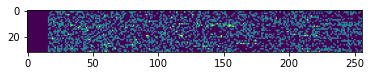

In [6]:
B=32

sample,p0 = pb.sample(B,op.L)
print(sample.shape)
ps = pb.logprobability(sample)

pvar,pmean = torch.var_mean(p0)

var,mean = torch.var_mean(abs(p0-ps))

print("Mean Difference:",mean.item(),"(Var[P])^0.5:",pvar.item()**0.5)

print("--------------------")



def get_indices(patch,L):
    sflip = torch.arange(L,device=device).to(torch.int64).reshape([1,L])
    sflip = patch(sflip).reshape(L)
    
    return sflip

with torch.no_grad():
    probs = Sampler.off_diag_labels(pb,sample,nloops=op.NLOOPS)[:,get_indices(pb.patch,op.L)]
    p2 = pb.off_diag_labels(sample,nloops=op.NLOOPS)

print("Mean Difference:",abs(probs-p2).mean().item(),"(Var[P])^0.5:",torch.var_mean(probs)[0].item()**0.5)
print(probs.mean(),p2.mean())
print(abs(probs-p2).max())
plt.imshow(abs(probs-p2).cpu())

In [3]:
pb.tokenize

Sequential(
  (0): Linear(in_features=16, out_features=128, bias=True)
  (1): Tanh()
)

In [3]:
h=Rydberg.DEFAULTS.copy()
h.name="RYDBERG"
h.Lx=16
h.Ly=16
op.dir="LPTF"
op.sub_directory="_PTFB"
op_full = dict(TRAIN=op,HAMILTONIAN=h,RYDBERG=h)

In [4]:
print(op)

L                             			256
Q                             			1
K                             			256
B                             			256
NLOOPS                        			16
steps                         			12000
dir                           			LPTF
lr                            			0.0005
sgrad                         			False
true_grad                     			False
sub_directory                 			_PTFB



In [ ]:
pb = torch.jit.script(pb)


beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op_full["TRAIN"].lr,
betas=(beta1,beta2)
)

mydir=setup_dir(op_full)
orig_stdout = sys.stdout
f = open(mydir+'\\output.txt', 'w')
sys.stdout = f
try:
    debug = reg_train(op_full,(pb,optimizer),printf=True,mydir=mydir)
except Exception as e:
    print(e)
sys.stdout = orig_stdout
f.close()

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


Output folder path established


In [2]:
op.steps=10

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op.lr,
betas=(beta1,beta2)
)

debug = reg_train(op,(pb,optimizer))
debug[-1,5]/op.L

Output folder path established
-0.3724 576
5,3.272|
48.44205188751221 10


0.26799843046400285

In [8]:
import os
os.system("python RNN_QSR.py hamiltonian=TFIM L=40 NLOOPS=10 h=-1 J=1 patch=1")

0

In [3]:
os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

0

In [4]:
import IPython
IPython.display.display(IPython.display.Javascript("IPython.notebook.save_notebook()"),include=['application/javascript'])

os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

0